Saving StockPrediction_data.csv to StockPrediction_data.csv


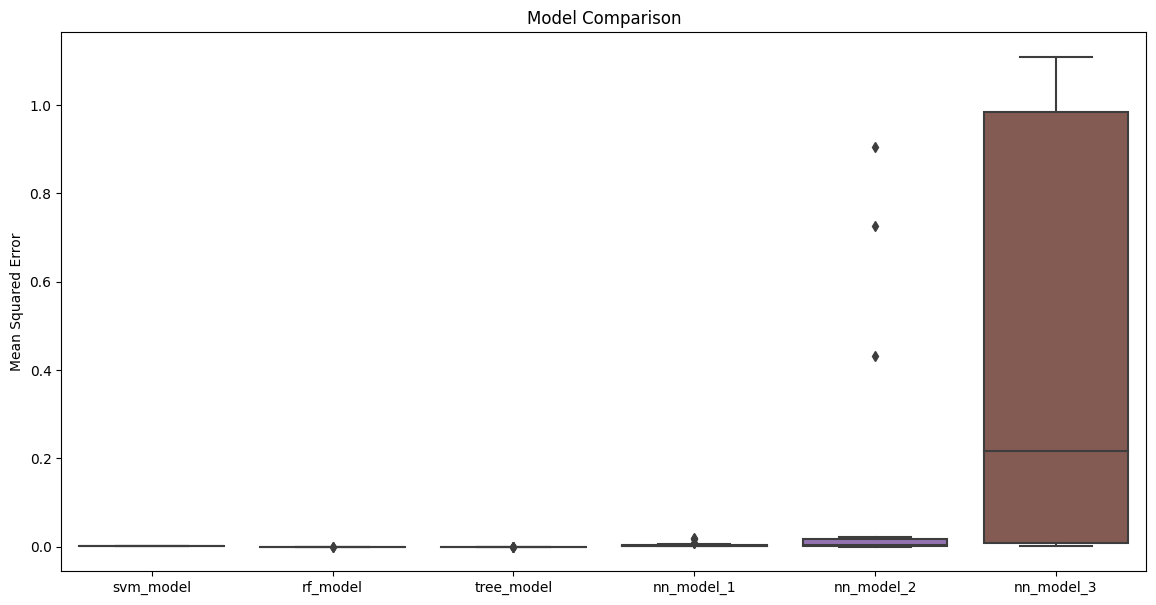

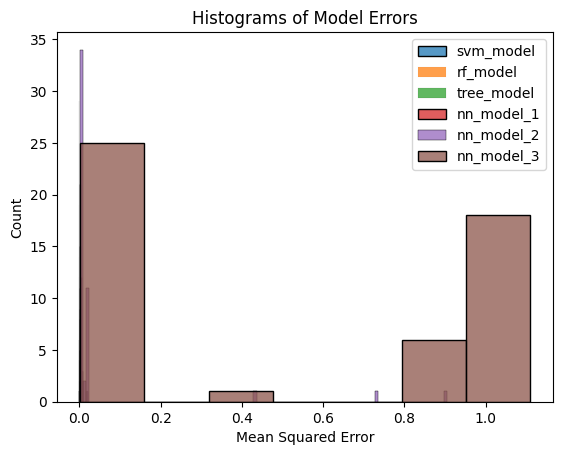

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, RepeatedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files
import io
import sklearn

# Uploading the dataset
uploaded = files.upload()

# Setting seed
np.random.seed(123)

# Reading the dataset
filename = list(uploaded.keys())[0]  # Dynamically capture the filename
data = pd.read_csv(io.BytesIO(uploaded[filename]))

# Removing or transforming 'Date'
data.drop('Date', axis=1, inplace=True)

# Normalizing numeric columns
numeric_cols = data.select_dtypes(include=np.number).columns
scaler = StandardScaler()
data[numeric_cols] = scaler.fit_transform(data[numeric_cols])

# Encoding 'Source' as a categorical variable
categorical_cols = ['Source']
ohe = OneHotEncoder()
ohe.fit(data[categorical_cols])
encoded_cats = ohe.transform(data[categorical_cols]).toarray()

# Checking scikit-learn version for compatibility
if sklearn.__version__ >= '0.22':
    cat_column_names = ohe.get_feature_names_out(categorical_cols)
else:
    cat_column_names = ohe.get_feature_names(categorical_cols)

encoded_cats_df = pd.DataFrame(encoded_cats, columns=cat_column_names)
data = pd.concat([data.drop(categorical_cols, axis=1), encoded_cats_df], axis=1)

# Defining cross-validation methods
cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=123)

# Defining models for comparison
hidden_configurations = [(3, 3, 5), (1,), (1, 1)]
nn_models = {f'nn_model_{idx}': MLPRegressor(hidden_layer_sizes=config, max_iter=500)
             for idx, config in enumerate(hidden_configurations, start=1)}

# Adding other models
models = {
    "svm_model": SVR(kernel='linear'),
    "rf_model": RandomForestRegressor(n_estimators=100),
    "tree_model": DecisionTreeRegressor(),
}
models.update(nn_models)  # Add the NN models to the dictionary

# Training and evaluating models using cross-validation
results = {}
for model_name, model in models.items():
    scores = cross_val_score(model, data.drop('Close', axis=1), data['Close'], scoring='neg_mean_squared_error', cv=cv)
    results[model_name] = scores

# Converting the results to a DataFrame for easier plotting
results_df = pd.DataFrame({k: -v for k, v in results.items()})  # Multiply by -1 to get MSE

# Creating a boxplot for comparison
plt.figure(figsize=(14, 7))
sns.boxplot(data=results_df)
plt.title('Model Comparison')
plt.ylabel('Mean Squared Error')
plt.show()

# Creating histograms for each model
for model_name, scores in results.items():
    sns.histplot(-scores, kde=False, label=model_name)  # Multiply by -1 to get MSE

plt.title('Histograms of Model Errors')
plt.xlabel('Mean Squared Error')
plt.ylabel('Count')
plt.legend()
plt.show()
